# Generate training and validation sets of streaks images

In [8]:
import numpy as np
from numpy import random
from PIL import Image
from PIL import ImageDraw
from PIL import ImageOps
from PIL import ImageFilter
import h5py
import time
import matplotlib.pyplot as plt
import matplotlib

matplotlib.use('PDF')

%matplotlib inline

Fix random seed to make sure we get reproducible results.

In [9]:
my_seed = 12345
random.seed(my_seed)
np.random.seed(my_seed)

Define a class that is used to generate streak images, which we will use to produce our training/validation/test sets

In [10]:
class StreakImageGenerator:
    def __init__(self, windowSize, maxDisplacement, nparticles,\
                 radius, uRms, phiRms):
        self.winSz = windowSize
        self.maxDisplacement = maxDisplacement
        self.nparticles = nparticles
        self.radius = radius
        self.uRms = uRms
        self.phiRms = phiRms
        self.threshold = 90
        self.image = Image.new('L', (self.winSz,self.winSz),(0))
        self.draw = ImageDraw.Draw(self.image)
        
    def generate(self, count = 1, sigma = None, binarize = False):
        images = np.zeros([count, 1, self.winSz, self.winSz], dtype=np.uint8)
        un0 = np.zeros(count, dtype=np.float32)
        phi0 = np.zeros(count, dtype=np.float32)
                        
        for i in range(0, count):
            images[i,0,:,:],un0[i],phi0[i] = self.generate_image(sigma, binarize)
            while np.count_nonzero(images[i,0,:,:]) < (un0[i]+(not binarize)*un0[i]*2):
                images[i,0,:,:],un0[i],phi0[i] = self.generate_image(sigma, binarize)

        return images,un0,phi0*180/np.pi
    
    def generate_image(self, sigma = None, binarize = False):
        self.draw.rectangle((0, 0, self.winSz, self.winSz), fill=(0)) # clean image
            
        #un0 = np.sqrt(random.uniform(0, 1)) * self.maxDisplacement
        un0 = random.uniform(1, self.maxDisplacement)
        phi0 = random.uniform(5. * np.pi / 180, np.pi) - np.pi / 2    
            
        nstreaks = random.randint(self.nparticles.start, self.nparticles.stop)
                        
        x_start = random.uniform(0, self.winSz, nstreaks)
        y_start = random.uniform(0, self.winSz, nstreaks)
        
        un = un0 + random.uniform(.0, self.uRms, nstreaks)
        phi = phi0 + random.uniform(-self.phiRms * np.pi / 180 / 2, self.phiRms * np.pi / 180 / 2, nstreaks)
            
        Dx = un * np.cos(phi)
        Dy = un * np.sin(phi)
        x_end = x_start + Dx 
        y_end = y_start + Dy 
            
        for j in range(nstreaks):
            width = random.randint(self.radius.start, self.radius.stop)
            intensity = random.randint(self.threshold, 255)
            self.draw.line(((x_start[j], y_start[j]), \
                            (x_end[j], y_end[j])), fill=intensity, width=width)
            
        if sigma is None:
            image = self.image;
        else:
            data = np.array(self.image.getdata(), dtype=float);
            data *= random.uniform(0.5, 1.5, size=self.winSz*self.winSz)
            self.image.putdata(data)
            image = self.image.filter(ImageFilter.GaussianBlur(radius = sigma))
            data = np.array(image.getdata())
            data[data > 255] = 255
            image.putdata(data)
            
        if binarize == True:
            image = image.point(lambda p: p > self.threshold and 255)
            
        return image,un0,phi0

Specify and generate training an validation sets

Generation finished, took 911.4s


(array([100230., 100269.,  99809.,  99672., 100470., 100153., 100024.,
         99059., 100327.,  99987.]),
 array([-84.99999  , -67.50003  , -50.000076 , -32.500114 , -15.000157 ,
          2.4998016,  19.99976  ,  37.499718 ,  54.99968  ,  72.49963  ,
         89.999596 ], dtype=float32),
 <a list of 10 Patch objects>)

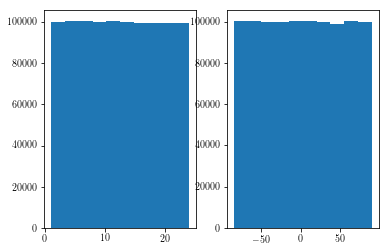

In [11]:
windowSize = 48
maxDisplacement = 24
nparticles = range(2, 10)
radius = range(1, 4)
uRms = 0
phiRms = 0

tic = time.time()
generator = StreakImageGenerator(windowSize, maxDisplacement, \
                                 nparticles, radius, uRms, phiRms)

count = 1000000;
images, Un, Phi = generator.generate(count = count, sigma = 1, binarize = False)

print("Generation finished, took {:.1f}s".format(time.time() - tic))

fig = plt.figure()
ax = fig.add_subplot(1,2,1)
plt.hist(Un)
ax = fig.add_subplot(1,2,2)
plt.hist(Phi)

Display random images and their parameters

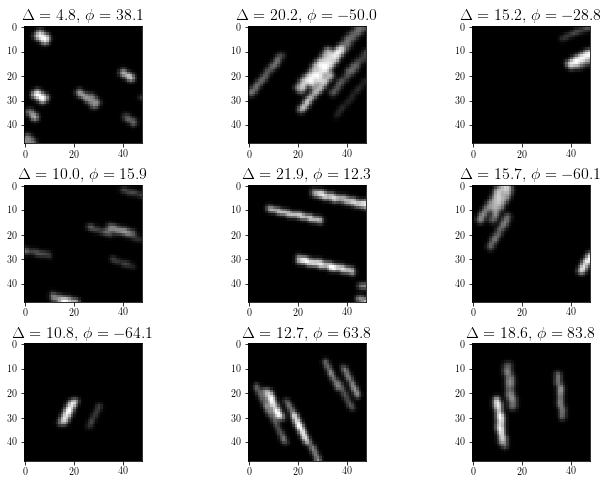

In [12]:
indices = random.randint(0, len(images), 9)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig = plt.figure()
for i in range(indices.size):
    ax = fig.add_subplot(3, 3, i + 1)
    plt.imshow(images[indices[i],0,:,:])
    ax.set_title("$\Delta = %.1f$, $\phi = %.1f$" % (Un[indices[i]], Phi[indices[i]]), fontsize=16)
    plt.gray()
    #print(np.count_nonzero(images[indices[i],0,:,:]))

fig.set_size_inches(np.array(fig.get_size_inches()) * 2)
fig.subplots_adjust(hspace=0.35, wspace = 0.01)
fig.savefig('paper/figs/figure1.png', dpi=300, format='png', bbox_inches='tight', pad_inches=0)

plt.show()

Save generated data

In [14]:
h5f = h5py.File('data/train_val_sets_grayscale_gradient_uniformDisp_n=1M.h5', 'w')
h5f.create_dataset('images', data=images, compression="gzip", compression_opts=6)
h5f.create_dataset('Un', data=Un, compression="gzip", compression_opts=6)
h5f.create_dataset('Phi', data=Phi, compression="gzip", compression_opts=6)
h5f.create_dataset('windowSize', data=windowSize)
h5f.create_dataset('maxDisplacement', data=maxDisplacement)
h5f.create_dataset('nparticles', data=nparticles)
h5f.create_dataset('radius', data=radius)
h5f.create_dataset('uRms', data=uRms)
h5f.create_dataset('phiRms', data=phiRms)

h5f.close()